# Model exploration

## Introduction

This notebook is used to explore the different models that we will use to predict if the player is worth inveting in. We will use the same data cleaning and feature selecting as the one found in the notebook `data_preprocessing.ipynb`. We will then search for the best hyperparameters for one ore two selected models. We might explore to put some threashold on the predicted values probabilities to adjust the prediction to better fit our metrics. As we disccused in the `data_preprocessing.ipynb` notebook, we will use first f1 score to evaluate our models. We will have alook at the recalls as well as we don't want to miss too much players. We will then select the best model and save it to use it in the API.

In [162]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt

pd.set_option('display.max_column', None)

data_path = './../data/nba_logreg.csv'
df = pd.read_csv(data_path)

FOLDS = 3

## Functions to preprocess and evaluate the data

In [163]:
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE, RandomOverSampler

def preprocessing(data, method=None, log=True):
    """
    Preprocessing data

    Parameters
    ----------
    data : pandas.DataFrame
        Data to be preprocessed
    method : str
        Method to be used for balancing data, default None
    """
    data = data.drop(['Name'], axis=1)
    data.loc[:, '3P%'] = data.loc[:, '3P%'].fillna(0)
    data = data.drop_duplicates()
    
    if method == 'oversample':
        ros = RandomOverSampler(random_state=0)
        X = data.drop('TARGET_5Yrs', axis=1)
        y = data['TARGET_5Yrs']
        X_resampled, y_resampled = ros.fit_resample(X, y)
        data = pd.concat([X_resampled, y_resampled], axis=1)
    elif method == 'undersample':
        rus = RandomUnderSampler(random_state=0)
        X = data.drop('TARGET_5Yrs', axis=1)
        y = data['TARGET_5Yrs']
        X_resampled, y_resampled = rus.fit_resample(X, y)
        data = pd.concat([X_resampled, y_resampled], axis=1).reset_index(drop=True)
    elif method == 'smote':
        sm = SMOTE(random_state=0)
        X = data.drop('TARGET_5Yrs', axis=1)
        y = data['TARGET_5Yrs']
        X_resampled, y_resampled = sm.fit_resample(X, y)
        data = pd.concat([X_resampled, y_resampled], axis=1)

    if log:
        X = data.drop('TARGET_5Yrs', axis=1)
        y = data['TARGET_5Yrs']
        X = np.log1p(X)
        data = pd.concat([X, y], axis=1)
    
    
    return data

In [164]:
from sklearn.metrics import confusion_matrix, recall_score, precision_score
from sklearn.model_selection import KFold

def score_classifier(dataset,classifier,labels, folds=FOLDS, verbose=True, threshold_func=None):
    
    """
    This function takes in a dataset, classifier and labels and returns the mean confusion matrix, recall, precision, accuracy and f1 score
    for the classifier using KFold cross validation with the number of folds specified by the user

    Parameters:
    dataset: pandas dataframe
    classifier: sklearn classifier
    labels: pandas series
    folds: int

    Returns:
    dict: dictionary containing mean confusion matrix, recall, precision, accuracy and f1 score
    """

    kf = KFold(n_splits=folds,random_state=50,shuffle=True)
    confusion_mat_list = []
    recall_list = []
    precision_list = []
    accuracy_list = []
    f1_list = []

    for training_ids,test_ids in kf.split(dataset):
        training_set = dataset.iloc[training_ids]
        training_labels = labels.iloc[training_ids]
        test_set = dataset.iloc[test_ids]
        test_labels = labels.iloc[test_ids]
        classifier.fit(training_set,training_labels)

        if threshold_func:
            predicted_labels = threshold_func(classifier, test_set)

        else:
            predicted_labels = classifier.predict(test_set)

        confusion_mat = confusion_matrix(test_labels,predicted_labels)
        recall = recall_score(test_labels, predicted_labels)
        precision = precision_score(test_labels, predicted_labels)
        accuracy = classifier.score(test_set, test_labels)
        f1 = 2 * (precision * recall) / (precision + recall)

        recall_list.append(recall)
        precision_list.append(precision)
        accuracy_list.append(accuracy)
        f1_list.append(f1)
        confusion_mat_list.append(confusion_mat)

    recall = np.mean(recall_list)
    precision = np.mean(precision_list)
    accuracy = np.mean(accuracy_list)
    f1 = np.mean(f1_list)
    confusion_mat = np.mean(confusion_mat_list,axis=0).astype(int)
    confusion_mat_df = pd.DataFrame(confusion_mat,columns=['Predicted 0','Predicted 1'],index=['Actual 0','Actual 1'])

    if verbose:
        print(f"confusion_mat: \n {confusion_mat_df}")
        print(f"recall:{recall}")
        print(f"precision:{precision}")
        print(f"accuracy:{accuracy}")
        print(f"f1:{f1}")
    return {'confusion_mat':confusion_mat,'recall':recall,'precision':precision,'accuracy':accuracy,'f1':f1, 'classifier':classifier}


## First score

Have a look at the score that we obtain if we apply the process of the test.py file to the data. We will use the same process to evaluate the models.

In [165]:
# first scores

from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline

df_test = df.copy()
X = df_test.drop(['TARGET_5Yrs', 'Name'], axis=1)
y = df_test['TARGET_5Yrs']

# fill nan
X.loc[:, '3P%'] = X.loc[:, '3P%'].fillna(0)

pipeline = Pipeline(steps=[('scaler', MinMaxScaler()), ('classifier', SVC())])

scores = score_classifier(X, pipeline, y)


confusion_mat: 
           Predicted 0  Predicted 1
Actual 0           88           81
Actual 1           49          227
recall:0.82197349073024
precision:0.737884007009773
accuracy:0.7082142033085542
f1:0.7774117527708234


The f1 score and recall are already quite good. We will try to see if we can improve them. We had a better f1 score with the logistic regression model and the preprocessing done in the previous notebook. Let's try other models to see if it improves.

## Models search

Let's first try a banch of different models to see which one is the best. we will standardize the data for each model has some of them are sensitive to the scale of the data.

In [166]:
# model search

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from xgboost import XGBClassifier

from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.preprocessing import PolynomialFeatures, StandardScaler

from sklearn.pipeline import Pipeline

target = 'TARGET_5Yrs'
balance_method = None

data_processed = preprocessing(df, balance_method, log=True)
models = [LogisticRegression(), RandomForestClassifier(), SVC(), GradientBoostingClassifier(), KNeighborsClassifier(), DecisionTreeClassifier(), AdaBoostClassifier(), XGBClassifier()]
model_names = ['LogisticRegression', 'RandomForestClassifier', 'SVC', 'GradientBoostingClassifier', 'KNeighborsClassifier', 'DecisionTreeClassifier', 'AdaBoostClassifier', 'XGBClassifier']

results = []

for model, model_name in zip(models, model_names):
    pipeline = Pipeline(steps=[('scaler', StandardScaler()), ('model', model)])
    result = score_classifier(data_processed.drop(target, axis=1), pipeline, data_processed[target], verbose=False)
    result['model_name'] = model_name
    results.append(result)

results_df = pd.DataFrame(results)
results_df = results_df.sort_values(by='f1', ascending=False)
results_df = results_df.reset_index(drop=True)
results_df

,confusion_mat,recall,precision,accuracy,f1,classifier,model_name
0,"[[88, 80], [43, 231]]",0.841649,0.742795,0.721384,0.789050,"(StandardScaler(), SVC())",SVC
1,"[[85, 82], [49, 225]]",0.821652,0.731715,0.702566,0.773921,"(StandardScaler(), LogisticRegression())",LogisticRegression
2,"[[90, 77], [56, 218]]",0.794443,0.737315,0.697285,0.764688,"(StandardScaler(), (DecisionTreeClassifier(max...",RandomForestClassifier
3,"[[89, 78], [57, 217]]",0.789963,0.733708,0.692008,0.760683,"(StandardScaler(), ([DecisionTreeRegressor(cri...",GradientBoostingClassifier
4,"[[84, 84], [59, 215]]",0.784002,0.719282,0.676210,0.750153,"(StandardScaler(), KNeighborsClassifier())",KNeighborsClassifier
5,"[[86, 81], [63, 211]]",0.769632,0.720752,0.673166,0.744344,"(StandardScaler(), XGBClassifier(base_score=No...",XGBClassifier
6,"[[90, 78], [67, 207]]",0.754728,0.726456,0.671684,0.740181,"(StandardScaler(), (DecisionTreeClassifier(max...",AdaBoostClassifier
7,"[[80, 87], [89, 185]]",0.674420,0.678830,0.599403,0.676054,"(StandardScaler(), DecisionTreeClassifier())",DecisionTreeClassifier


We observe that SVC has the best results among all the models that we tested. The standart scaler seems to have decrease the performance of the logistic regression model. Let's to use only the features that we selected in the notebook.

In [167]:
# model search - feature selection

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from xgboost import XGBClassifier

from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.preprocessing import PolynomialFeatures, StandardScaler

from sklearn.pipeline import Pipeline

target = 'TARGET_5Yrs'
balance_method = None
features_selected = ['GP', 'FTM', 'OREB', 'STL', 'BLK', 'AST']

data_processed = preprocessing(df, balance_method)
X = data_processed[features_selected]
y = data_processed[target]

models = [LogisticRegression(), RandomForestClassifier(), SVC(), GradientBoostingClassifier(), KNeighborsClassifier(), DecisionTreeClassifier(), AdaBoostClassifier(), XGBClassifier()]
model_names = ['LogisticRegression', 'RandomForestClassifier', 'SVC', 'GradientBoostingClassifier', 'KNeighborsClassifier', 'DecisionTreeClassifier', 'AdaBoostClassifier', 'XGBClassifier']

results = []

for model, model_name in zip(models, model_names):
    pipeline = Pipeline(steps=[('scaler', StandardScaler()), ('model', model)])
    result = score_classifier(X, pipeline, y, verbose=False)
    result['model_name'] = model_name
    results.append(result)

results_df = pd.DataFrame(results)
results_df = results_df.sort_values(by='f1', ascending=False)
results_df = results_df.reset_index(drop=True)
results_df

,confusion_mat,recall,precision,accuracy,f1,classifier,model_name
0,"[[87, 80], [44, 230]]",0.838086,0.740141,0.717612,0.786010,"(StandardScaler(), LogisticRegression())",LogisticRegression
1,"[[90, 77], [46, 228]]",0.829594,0.746411,0.719877,0.785756,"(StandardScaler(), SVC())",SVC
2,"[[89, 79], [62, 212]]",0.773396,0.728899,0.681474,0.750388,"(StandardScaler(), ([DecisionTreeRegressor(cri...",GradientBoostingClassifier
3,"[[82, 85], [58, 216]]",0.787385,0.715905,0.674678,0.749558,"(StandardScaler(), KNeighborsClassifier())",KNeighborsClassifier
4,"[[89, 78], [63, 211]]",0.770249,0.729166,0.679976,0.748985,"(StandardScaler(), (DecisionTreeClassifier(max...",AdaBoostClassifier
5,"[[85, 83], [60, 214]]",0.778192,0.719929,0.675444,0.747850,"(StandardScaler(), (DecisionTreeClassifier(max...",RandomForestClassifier
6,"[[78, 89], [74, 200]]",0.727805,0.689585,0.629502,0.708032,"(StandardScaler(), XGBClassifier(base_score=No...",XGBClassifier
7,"[[81, 86], [90, 184]]",0.670443,0.680804,0.600903,0.675258,"(StandardScaler(), DecisionTreeClassifier())",DecisionTreeClassifier


We observe a decrease of performance for the best models. Let's try to remove the satandart scaler for logistic though it seems to have a better performance without it.

In [169]:
# model search - feature selection

from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.preprocessing import PolynomialFeatures, StandardScaler

from sklearn.pipeline import Pipeline

target = 'TARGET_5Yrs'
balance_method = None
features_selected = ['GP', 'FTM', 'OREB', 'STL', 'BLK', 'AST']

data_processed = preprocessing(df, balance_method)
X = data_processed[features_selected]
y = data_processed[target]

lr = Pipeline(steps=[('model', LogisticRegression(solver='liblinear'))])
svc = Pipeline(steps=[('scaler', StandardScaler()), ('model', SVC())])

models = [lr, svc]
model_names = ['LogisticRegression', 'SVC']

results = []

for model, model_name in zip(models, model_names):
    result = score_classifier(X, model, y, verbose=False)
    result['model_name'] = model_name
    results.append(result)

results_df = pd.DataFrame(results)
results_df = results_df.sort_values(by='f1', ascending=False)
results_df = results_df.reset_index(drop=True)
results_df

,confusion_mat,recall,precision,accuracy,f1,classifier,model_name
0,"[[81, 86], [38, 236]]",0.860947,0.732446,0.718374,0.791193,(LogisticRegression(solver='liblinear')),LogisticRegression
1,"[[90, 77], [46, 228]]",0.829594,0.746411,0.719877,0.785756,"(StandardScaler(), SVC())",SVC


We observe that the logistic regression model has the best performance if we remove the standart scaler for it. Let's try to tune the hyperparameters of this model to see if we can improve the performance. However let's remind that SVC had better performances on all features selected.

## Hyperparameters tuning

Let's first try on the logistic regression model. let's add an autolmatic selection of the best features with ANOVA test, polynomial features, search for the best C (inverse of the regularization strength) and the best solver.

In [202]:
from sklearn.model_selection import RandomizedSearchCV

target = 'TARGET_5Yrs'
balance_method = None

data_processed = preprocessing(df, balance_method)
X = data_processed.drop(target, axis=1)
y = data_processed[target]

pipeline = Pipeline(steps=[
    ('polynomial_features', PolynomialFeatures(2, include_bias=False)), 
    ('select_k_best', SelectKBest(f_classif, k=10)), 
    ('model', LogisticRegression())])

param_grid = {'polynomial_features__degree': range(1, 5),
                'select_k_best__k': range(1, 19),
                'model__C': [0.01, 0.1, 1, 10],
                'model__solver': ['liblinear', 'lbfgs', 'saga']}

cv = KFold(n_splits=FOLDS,random_state=50,shuffle=True)

random_search = RandomizedSearchCV(pipeline, param_grid, cv=cv, scoring='f1', n_jobs=-1, verbose=1, n_iter=200)
random_search.fit(X, y)

print(random_search.best_params_)

Fitting 3 folds for each of 200 candidates, totalling 600 fits
{'select_k_best__k': 1, 'polynomial_features__degree': 2, 'model__solver': 'liblinear', 'model__C': 1}


Let's try again to improve C.

In [203]:
from sklearn.model_selection import RandomizedSearchCV

target = 'TARGET_5Yrs'
balance_method = None

data_processed = preprocessing(df, balance_method)
X = data_processed.drop(target, axis=1)
y = data_processed[target]

pipeline = Pipeline(steps=[
    ('polynomial_features', PolynomialFeatures(1, include_bias=False)), 
    ('select_k_best', SelectKBest(f_classif, k=10)), 
    ('model', LogisticRegression())])

param_grid = {'polynomial_features__degree': range(1, 3),
                'select_k_best__k': range(1, 19),
                'model__C': [0.07, 0.08, 0.09, 0.1, 0.11, 0.12],
                'model__solver': ['liblinear']}

cv = KFold(n_splits=FOLDS,random_state=50,shuffle=True)

random_search = RandomizedSearchCV(pipeline, param_grid, cv=cv, scoring='f1', n_jobs=-1, verbose=1, n_iter=100)
random_search.fit(X, y)

print(random_search.best_params_)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


{'select_k_best__k': 15, 'polynomial_features__degree': 1, 'model__solver': 'liblinear', 'model__C': 0.1}


Let's evaluate the model with the best parameters.

In [204]:
target = 'TARGET_5Yrs'
balance_method = None

data_processed = preprocessing(df, balance_method)
X = data_processed.drop(target, axis=1)
y = data_processed[target]

pipeline = Pipeline(steps=[
    ('polynomial_features', PolynomialFeatures(1, include_bias=False)), 
    ('select_k_best', SelectKBest(f_classif, k=15)), 
    ('model', LogisticRegression(C=0.1, solver='liblinear'))])

result = score_classifier(X, pipeline, y, verbose=False)
result['model_name'] = 'LogisticRegression'

result

{'confusion_mat': array([[ 76,  92],
        [ 40, 234]]),
 'recall': 0.8545865405577636,
 'precision': 0.71845809459442,
 'accuracy': 0.7017949739367877,
 'f1': 0.780249720524941,
 'classifier': Pipeline(steps=[('polynomial_features',
                  PolynomialFeatures(degree=1, include_bias=False)),
                 ('select_k_best', SelectKBest(k=15)),
                 ('model', LogisticRegression(C=0.1, solver='liblinear'))]),
 'model_name': 'LogisticRegression'}

We observe that the model has a little bit less good performance than the one with the features that we selected. We will keep in mind the other hyperparameters though. Let's try to tune the SVC model.

In [205]:
from sklearn.model_selection import RandomizedSearchCV

target = 'TARGET_5Yrs'
balance_method = None

data_processed = preprocessing(df, balance_method)
X = data_processed.drop(target, axis=1)
y = data_processed[target]

pipeline = Pipeline(steps=[
    ('polynomial_features', PolynomialFeatures(2, include_bias=False)), 
    ('select_k_best', SelectKBest(f_classif, k=10)),
    ('scaler', StandardScaler()), 
    ('model', SVC())])

param_grid = {'polynomial_features__degree': range(1, 3),
                'select_k_best__k': range(1, 19),
                'model__C': [0.01, 0.1, 1, 10, 100, 1000],
                'model__kernel': ['rbf'],
                'model__gamma': ['scale']}

cv = KFold(n_splits=FOLDS,random_state=50,shuffle=True)


random_search = RandomizedSearchCV(pipeline, param_grid, scoring='f1', cv=cv, n_jobs=-1, verbose=1, n_iter=100)
random_search.fit(X, y)

print(random_search.best_params_)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


{'select_k_best__k': 18, 'polynomial_features__degree': 1, 'model__kernel': 'rbf', 'model__gamma': 'scale', 'model__C': 1}


Let's see how it scores.

In [207]:
target = 'TARGET_5Yrs'
balance_method = None

data_processed = preprocessing(df, balance_method)
X = data_processed.drop(target, axis=1)
y = data_processed[target]

pipeline = Pipeline(steps=[
    ('polynomial_features', PolynomialFeatures(1, include_bias=False)), 
    ('select_k_best', SelectKBest(f_classif, k=18)), 
    ('scaler', StandardScaler()), 
    ('model', SVC(C=1, kernel='rbf', gamma='scale'))])

result = score_classifier(X, pipeline, y, verbose=False)
result['model_name'] = 'SVC'

result

{'confusion_mat': array([[ 86,  81],
        [ 43, 231]]),
 'recall': 0.8404839764551996,
 'precision': 0.7393898108095481,
 'accuracy': 0.7176201614523219,
 'f1': 0.7866000753823666,
 'classifier': Pipeline(steps=[('polynomial_features',
                  PolynomialFeatures(degree=1, include_bias=False)),
                 ('select_k_best', SelectKBest(k=18)),
                 ('scaler', StandardScaler()), ('model', SVC(C=1))]),
 'model_name': 'SVC'}

We observe a slight loss of performance compare to the logistic regression model. However let's remind that we had a good performance with all parameters selected and that the Random search doesn't search in the full space since it's very big. Let's try to see of we can defind a threashold to improve the F1 score on the logistic regression model with selected paramaters from last notebooks.

Let's tune hyperparameters of the logistic regression model with the features that we selected.

In [209]:
from sklearn.model_selection import GridSearchCV, KFold
target = 'TARGET_5Yrs'
balance_method = None

selected_features = ['GP', 'FTM', 'OREB', 'STL', 'BLK', 'AST']
data_processed = preprocessing(df, balance_method)
X = data_processed[selected_features]
y = data_processed[target]

pipeline = Pipeline(steps=[
    ('model', LogisticRegression())])

param_grid = {
                'model__C': [0.8, 0.85, 0.9, 0.95, 1, 1.05, 1.1, 1.2],
                'model__solver': ['liblinear', 'lbfgs', 'saga'],
                'model__penalty': ['l1', 'l2', 'elasticnet', 'none']}

cv = KFold(n_splits=FOLDS, random_state=50, shuffle=True)

random_search = GridSearchCV(pipeline, param_grid, cv=cv, scoring='f1',  verbose=1)
random_search.fit(X, y)

print(random_search.best_params_)

Fitting 3 folds for each of 96 candidates, totalling 288 fits


d:\Documents\Professionnels\Stage_fin_etude\MPDATA\NBA_prediction\venv\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
d:\Documents\Professionnels\Stage_fin_etude\MPDATA\NBA_prediction\venv\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
d:\Documents\Professionnels\Stage_fin_etude\MPDATA\NBA_prediction\venv\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
d:\Documents\Professionnels\Stage_fin_etude\MPDATA\NBA_prediction\venv\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
d:\Documents\Professionnels\Stage_fin_etude\MPDATA\NBA_prediction\venv\lib\site-packages\sklearn\linear_

{'model__C': 1.05, 'model__penalty': 'l2', 'model__solver': 'liblinear'}


d:\Documents\Professionnels\Stage_fin_etude\MPDATA\NBA_prediction\venv\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
d:\Documents\Professionnels\Stage_fin_etude\MPDATA\NBA_prediction\venv\lib\site-packages\sklearn\linear_model\_logistic.py:1183: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
d:\Documents\Professionnels\Stage_fin_etude\MPDATA\NBA_prediction\venv\lib\site-packages\sklearn\linear_model\_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
d:\Documents\Professionnels\Stage_fin_etude\MPDATA\NBA_prediction\venv\lib\site-packages\sklearn\linear_model\_logistic.py:1183: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.

In [213]:
target = 'TARGET_5Yrs'
balance_method = None

features_selected = ['GP', 'FTM', 'OREB', 'STL', 'BLK', 'AST']

data_processed = preprocessing(df, balance_method)
X = data_processed[features_selected]
y = data_processed[target]
pipeline = Pipeline(steps=[
    ('model', LogisticRegression(solver='liblinear', C=1.05))])

result = score_classifier(X, pipeline, y, verbose=True)


confusion_mat: 
           Predicted 0  Predicted 1
Actual 0           82           85
Actual 1           38          236
recall:0.8596652747731884
precision:0.7343752789417944
accuracy:0.7198792001607033
f1:0.7918183519874004


That's the best score that we got with the logistic regression model. Let's try to see if we can improve it with a threashold.

## Threashold tuning

Let's tune the threshold for the logistic regression model.

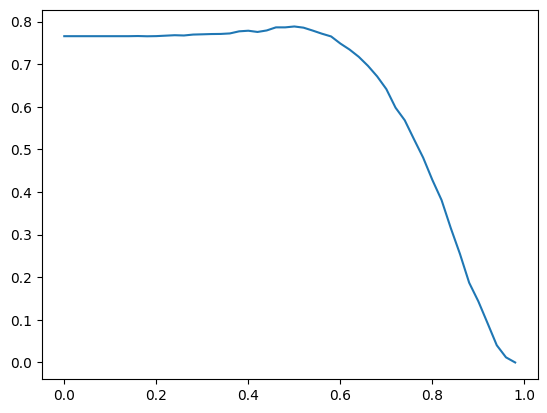

0.5

In [224]:
from sklearn.metrics import f1_score
target = 'TARGET_5Yrs'
balance_method = None
features_selected = ['GP', 'FTM', 'OREB', 'STL', 'BLK', 'AST']

data_processed = preprocessing(df, balance_method)
X = data_processed[features_selected]
y = data_processed[target]

lr = Pipeline(steps=[('model', LogisticRegression(C=1.05, solver='liblinear'))])

result = score_classifier(X, lr, y, verbose=False)
probabilities = lr.predict_proba(X)

thresholds = np.arange(0, 1, 0.02)
scores = []
for threshold in thresholds:
    predictions = probabilities[:, 1] > threshold
    scores.append(f1_score(y, predictions))

plt.plot(thresholds, scores)
plt.show()

thresholds[np.argmax(scores)]


We find that the best threshold is 0.5 which doesn't change the score.

In [225]:
def predict_threshold(model, X, threshold=0.5):
    probabilities = model.predict_proba(X)
    predictions = probabilities[:, 1] > threshold
    return predictions

In [226]:
# logistic regression with threshold

target = 'TARGET_5Yrs'
balance_method = None
features_selected = ['GP', 'FTM', 'OREB', 'STL', 'BLK', 'AST']

data_processed = preprocessing(df, balance_method)
X = data_processed[features_selected]
y = data_processed[target]

lr = Pipeline(steps=[('model', LogisticRegression(C=1.05, solver='liblinear'))])

result = score_classifier(X, lr, y, verbose=False, threshold_func=predict_threshold)

result


{'confusion_mat': array([[ 82,  85],
        [ 38, 236]]),
 'recall': 0.8596652747731884,
 'precision': 0.7343752789417944,
 'accuracy': 0.7198792001607033,
 'f1': 0.7918183519874004,
 'classifier': Pipeline(steps=[('model', LogisticRegression(C=1.05, solver='liblinear'))])}

Let's try to tune the threshold for the SVC model.

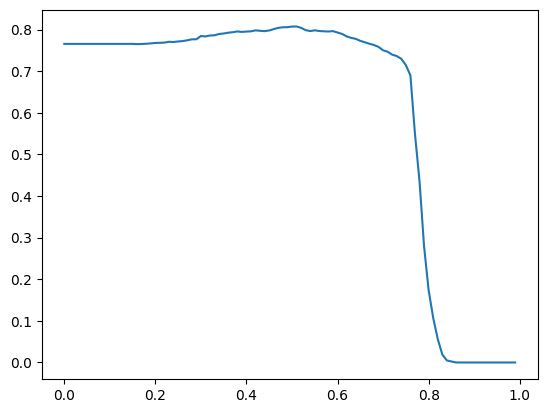

0.51

In [230]:
target = 'TARGET_5Yrs'
balance_method = None
features_selected = df.columns.drop(['TARGET_5Yrs', 'Name'])

data_processed = preprocessing(df, balance_method)
X = data_processed[features_selected]
y = data_processed[target]

lr = Pipeline(steps=[
    ('scaler', StandardScaler()),
    ('model', SVC(C=1, kernel='rbf', gamma='scale', probability=True))])

result = score_classifier(X, lr, y, verbose=False)
probabilities = lr.predict_proba(X)

thresholds = np.arange(0, 1, 0.01)
scores = []
for threshold in thresholds:
    predictions = probabilities[:, 1] > threshold
    scores.append(f1_score(y, predictions))

plt.plot(thresholds, scores)
plt.show()

thresholds[np.argmax(scores)]

In [231]:
def predict_threshold_svc(model, X, threshold=0.51):
    probabilities = model.predict_proba(X)
    predictions = probabilities[:, 1] > threshold
    return predictions

In [232]:
target = 'TARGET_5Yrs'
balance_method = None

data_processed = preprocessing(df, balance_method)
X = data_processed.drop(target, axis=1)
y = data_processed[target]

lr = Pipeline(steps=[
    ('scaler', StandardScaler()),
    ('model', SVC(C=1, kernel='rbf', gamma='scale', probability=True))])

result = score_classifier(X, lr, y, verbose=False, threshold_func=predict_threshold_svc)

result


{'confusion_mat': array([[ 82,  85],
        [ 39, 235]]),
 'recall': 0.8566685113447704,
 'precision': 0.7329390814485505,
 'accuracy': 0.7213840910561133,
 'f1': 0.7899337155728868,
 'classifier': Pipeline(steps=[('scaler', StandardScaler()),
                 ('model', SVC(C=1, probability=True))])}

That's the best score we got so far with the SVC model. But it is still lower than the logistic regression model.

## Overfitting

We might have overfitting in our model. Let's see the overfitting of the logistic regression model fit overfitting curve.

In [233]:
from sklearn.model_selection import learning_curve

def plot_learning_curve(estimator, title, X, y, axes=None, ylim=None, cv=None, n_jobs=None, train_sizes=np.linspace(0.1, 1.0, 5)):
    """
    Generate a simple plot of the test and training learning curve.

    Parameters
    ----------
    estimator : object type that implements the "fit" and "predict" methods
    title : string
        Title for the chart.
    X : array-like, shape (n_samples, n_features)
        Training vector, where n_samples is the number of samples and n_features is the number of features.
    y : array-like, shape (n_samples)
        Target relative to X for classification or regression.
    axes : array of 3 axes, optional (default=None)
        Axes to use for plotting the learning curves. If None, use current axes.
    ylim : tuple of shape (ymin, ymax), optional
        Defines minimum and maximum yvalues plotted.
    cv : int, cross-validation generator or an iterable, optional
        Determines the cross-validation splitting strategy. Possible inputs for cv are:
          - None, to use the default 5-fold cross-validation,
          - integer, to specify the number of folds.
          - An object to be used as a cross-validation generator.
          - An iterable yielding train/test splits.
    n_jobs : int or None, optional (default=None)
        Number of jobs to run in parallel.
    train_sizes : array-like, shape (n_ticks,)
        Relative or absolute numbers of training examples that will be used to generate the learning curve.
    """
    if axes is None:
        _, axes = plt.subplots(1, 1, figsize=(20, 5))

    axes.set_title(title)
    if ylim is not None:
        axes.set_ylim(*ylim)
    axes.set_xlabel("Training examples")
    axes.set_ylabel("Score")

    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes, scoring="f1")
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    axes.grid()
    axes.fill_between(train_sizes, train_scores_mean - train_scores_std,
                      train_scores_mean + train_scores_std, alpha=0.1,
                      color="r")
    axes.fill_between(train_sizes, test_scores_mean - test_scores_std,
                      test_scores_mean + test_scores_std, alpha=0.1, color="g")
    axes.plot(train_sizes, train_scores_mean, 'o-', color="r",
              label="Training score")
    axes.plot(train_sizes, test_scores_mean, 'o-', color="g",
              label="Cross-validation score")
    axes.legend(loc="best")

    return plt


<module 'matplotlib.pyplot' from 'd:\\Documents\\Professionnels\\Stage_fin_etude\\MPDATA\\NBA_prediction\\venv\\lib\\site-packages\\matplotlib\\pyplot.py'>

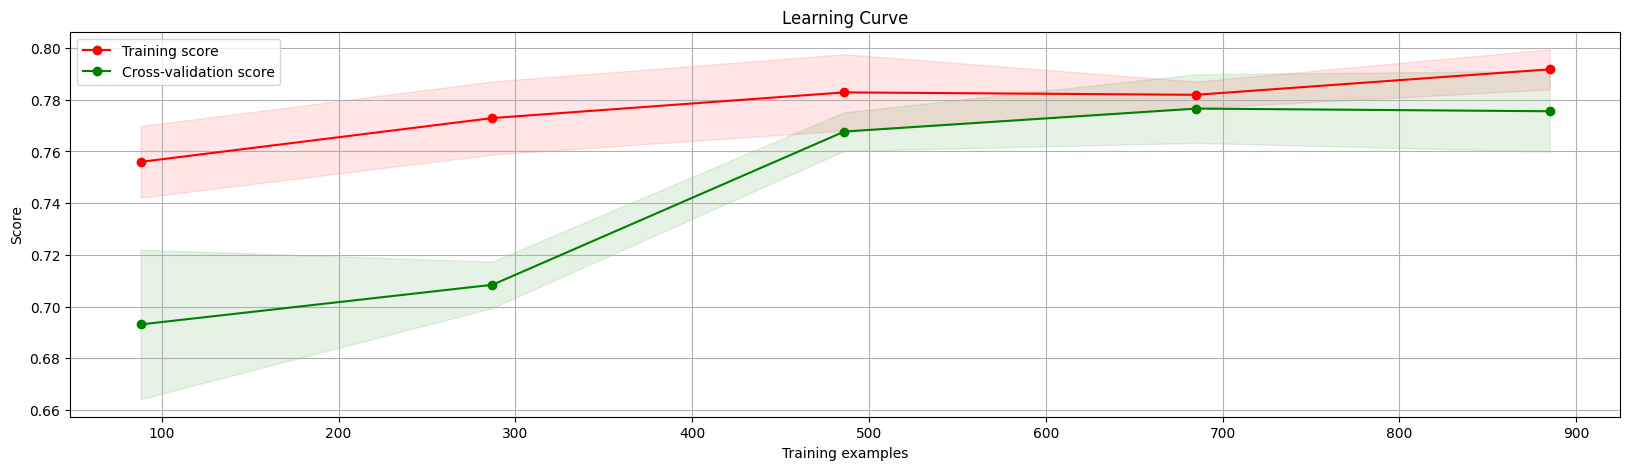

In [234]:
target = 'TARGET_5Yrs'
balance_method = None

data_processed = preprocessing(df, balance_method)
X = data_processed.drop(target, axis=1)
y = data_processed[target]

lr = Pipeline(steps=[
    ('model', LogisticRegression(C=1.05, solver='liblinear'))])

cv = KFold(n_splits=FOLDS,random_state=50,shuffle=True)

plot_learning_curve(lr, 'Learning Curve', X, y, cv=cv, n_jobs=-1)

This learning curve suggests that the model benefits from more training data. Initially, there is a significant gap between the training and validation scores, indicating possible overfitting with fewer data points. As more data is provided, the validation score increases, suggesting that the model is generalizing better. The training and validation scores converge as the number of training examples grows, which is a sign that the model is becoming more stable and should perform more consistently on unseen data. However, the curve is starting to plateau, which suggests that adding more training data beyond this point may yield diminishing returns in terms of model performance improvement.

## Trade-off between precision and recall

The trade-off between precision and recall often comes into play when a model's threshold is adjusted. The threshold determines the point at which a probability score is classified as a positive outcome. Lowering the threshold may increase recall but decrease precision, as the model predicts more positives, making it more sensitive to detecting actual positives but at the risk of more false positives. Conversely, raising the threshold may increase precision but decrease recall, as the model becomes more conservative in predicting positives, thus reducing the risk of false positives but potentially missing out on actual positives.

In practice, the appropriate balance between precision and recall is context-dependent. A perfect model would have both high precision and high recall, but typically as one increases, the other decreases. The key is to understand the consequences of false positives and false negatives in the specific application and adjust the model to minimize the most critical type of error. The F1 score is one metric that combines both precision and recall into a single number, providing a way to find a balance between the two, especially when we aim for a model that does not excessively favor one over the other.

In [239]:
from sklearn.model_selection import KFold
from sklearn.metrics import precision_recall_curve, auc
import numpy as np
import matplotlib.pyplot as plt

def calculate_and_plot_auc_pr_cv(model, X, y, cv):
    tprs = []
    aucs = []
    mean_recall = np.linspace(0, 1, 100)

    fig, ax = plt.subplots()

    for i, (train, test) in enumerate(cv.split(X, y)):
        model.fit(X.iloc[train], y.iloc[train])
        probas_ = model.predict_proba(X.iloc[test])
        
        precision, recall, _ = precision_recall_curve(y.iloc[test], probas_[:, 1])
        auc_score = auc(recall, precision)
        aucs.append(auc_score)

        interp_precision = np.interp(mean_recall, recall[::-1], precision[::-1])
        interp_precision[0] = 1.0
        tprs.append(interp_precision)
        ax.plot(recall, precision, lw=1, alpha=0.3, label=f'Fold {i+1} (AUC = {auc_score:.2f})')

    mean_tpr = np.mean(tprs, axis=0)
    mean_auc = auc(mean_recall, mean_tpr)
    std_auc = np.std(aucs)

    ax.plot(mean_recall, mean_tpr, color='b', label=f'Mean PR (AUC = {mean_auc:.2f} $\pm$ {std_auc:.2f})', lw=2, alpha=0.8)
    ax.set(xlim=[0, 1], ylim=[0, 1], title="Precision-Recall curve")
    ax.legend(loc="best")
    plt.show()

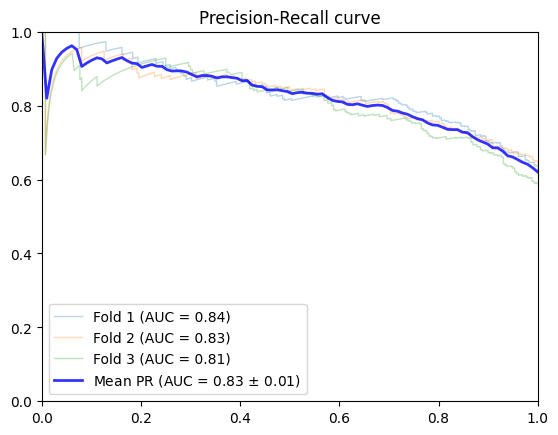

In [240]:
target = 'TARGET_5Yrs'
balance_method = None

data_processed = preprocessing(df, balance_method)
X = data_processed.drop(target, axis=1)
y = data_processed[target]

lr = Pipeline(steps=[
    ('model', LogisticRegression(C=1.05, solver='liblinear'))])

cv = KFold(n_splits=FOLDS,random_state=50,shuffle=True)

calculate_and_plot_auc_pr_cv(lr, X, y, cv)

The AUC for the PR curve is a single number summary of the curve and is useful for comparing different models. A higher AUC indicates better model performance. In this case, the AUC values are quite high, suggesting that the model has a good balance of precision and recall across all folds.

The graph also shows that precision starts high when recall is low, which is typical for PR curves. As recall increases (meaning the model is identifying more positive cases), precision tends to decrease unless the model is perfect. This trade-off is visible as the curves slope downwards moving from left to right.

The relatively close grouping of the lines and the narrow standard deviation in the mean PR curve suggest that the model's performance is consistent across different subsets of the data. This consistency is a good indicator that the model is stable and not highly sensitive to the specific data on which it was trained

## Final score and saving the model

In [241]:
target = 'TARGET_5Yrs'
balance_method = None

features_selected = ['GP', 'FTM', 'OREB', 'STL', 'BLK', 'AST']

data_processed = preprocessing(df, balance_method)
X = data_processed[features_selected]
y = data_processed[target]
pipeline = Pipeline(steps=[
    ('model', LogisticRegression(solver='liblinear', C=1.05))])

result = score_classifier(X, pipeline, y, verbose=True)

confusion_mat: 
           Predicted 0  Predicted 1
Actual 0           82           85
Actual 1           38          236
recall:0.8596652747731884
precision:0.7343752789417944
accuracy:0.7198792001607033
f1:0.7918183519874004


In [242]:
# save model

import joblib

target = 'TARGET_5Yrs'
balance_method = None
features_selected = ['GP', 'FTM', 'OREB', 'STL', 'BLK', 'AST']

data_processed = preprocessing(df, balance_method)
X = data_processed[features_selected]
y = data_processed[target]

lr = Pipeline(steps=[('model', LogisticRegression(C=1.05, solver='liblinear'))])
lr.fit(X, y)

joblib.dump(lr, './../models/model_1.pkl')





['./../models/model_1.pkl']

In [243]:
# load model

import joblib

model = joblib.load('./../models/model_1.pkl')

model.predict_proba(X)


array([[0.39217518, 0.60782482],
       [0.34566767, 0.65433233],
       [0.39018598, 0.60981402],
       ...,
       [0.39337211, 0.60662789],
       [0.45496332, 0.54503668],
       [0.58618028, 0.41381972]])

## Conclusion

We observe that the logistic regression model has the best performance. We will use it in the API. We will use the features that we selected in the notebook `data_preprocessing.ipynb`. We will use the hyperparameters that we found in this notebook. We will use the threshold of 0.5. We will use the model without the standart scaler. We will use the model without the polynomial features. We will use the model without the automatic feature selection.

Final performance for
folds = 3 \
random_state = 50 \
model = LogisticRegression(C=0.1, solver='liblinear')

`f1` = 0.7918183519874004 \
`recall` = 0.8596652747731884 \
`precision` = 0.7343752789417944 \
`accuracy` = 0.7198792001607033
